#  Часть №1. Считывание исходного временного ряда и его проверка на стационарность

## Считывание временного ряда

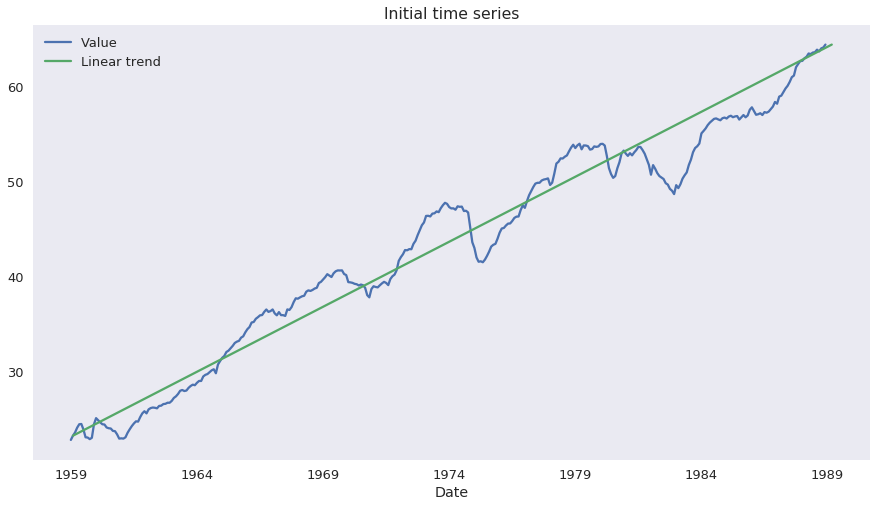

In [139]:
# Вывод графиков после ячейки с кодом их рисования.
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import statsmodels.api as sm
from sklearn.metrics import r2_score

height_plot = 8  # Высота графиков.
width_plot = 15  # Ширина графиков.

plt.rcParams['figure.figsize'] = (width_plot, height_plot)

sns.set()  # Параметры по умолчанию.
sns.set_style("dark")  # Стиль.
sns.set_context("talk")  # Задание масштаба графиков.

data = pd.read_csv('training.csv',
                   sep=',',
                   index_col=['Date'],
                   parse_dates=True)


data.plot(title='Initial time series')
plt.plot([-131, 230], [data['Value'][1],
                       data['Value'][-1]], label='Linear trend')
plt.legend();

## Проверка ряда на стационарность графическим способом

Для проверки ряда на стационарность построим следующие графики:

1. График самого ряда.
1. График скользящего среднего.
1. График стандартного отклонения.

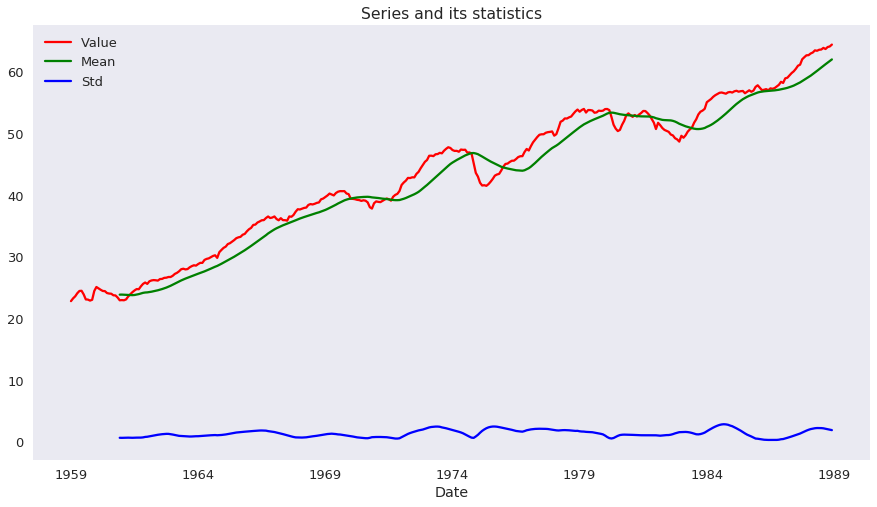

In [140]:
def calc_mean_std(data, n):
    mean = data['Value'].rolling(window=n, center=False).mean()
    std = data['Value'].rolling(window=n, center=False).std()
    dataFrame = pd.DataFrame(
        {'Value': data['Value'], 'Mean': mean, 'Std': std}, data.index)

    return dataFrame[['Value', 'Mean', 'Std']]


stat = calc_mean_std(data, 24)
stat.plot(title='Series and its statistics', style=['-r', '-g', '-b']);

## Анализ графика
Можно сделать следующие выводы:
1. По графику стандартного отклонения видно, что у временего ряда нет рассеивания значений. На основания только этого графика можно предположить, что временной ряд достоверен.
2. По графику значений ряда и его среднего видно, что у ряда есть ярко выраженный тренд (приближенно похожий на линейный), то есть, ряд не стационарен. 

В итоге пришли к выводу, что ряд не стационарен.

# Часть №2. Разложение временного ряда на тренд, сезональность, остаток

### Построим график тренда, сезональности и остатка исходного ряда для аддитивной и мультипликативной моделей

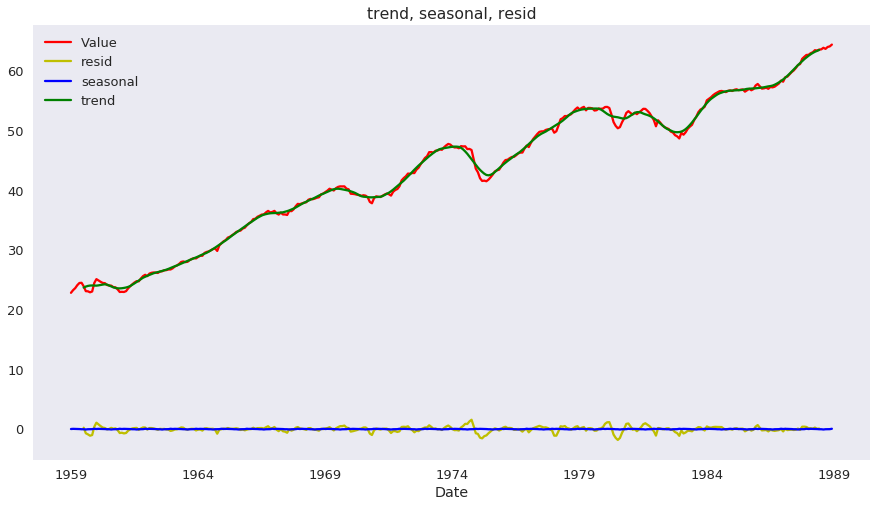

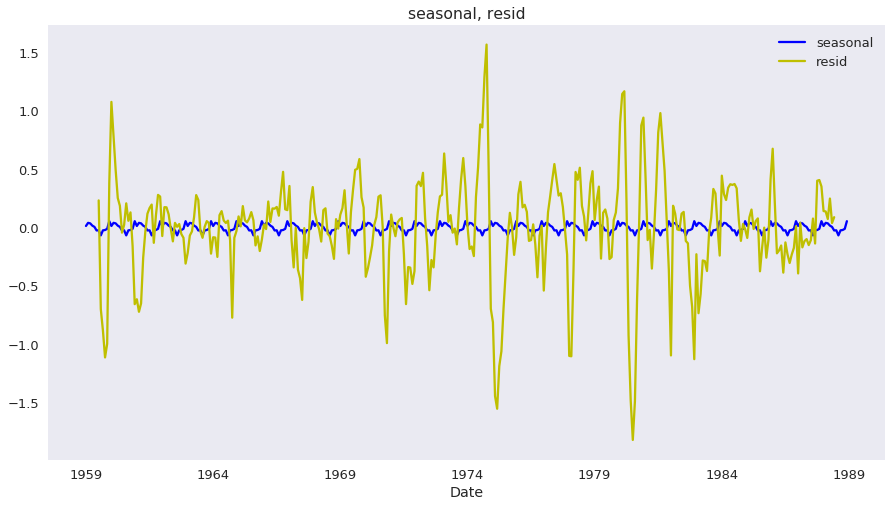

In [141]:
y = data['Value']
additdec = sm.tsa.seasonal_decompose(y, model='additive')
multydec = sm.tsa.seasonal_decompose(y, model='multiplicative')

# построим график тренда, сезональности и остатка для аддитивной модели
tsr = pd.DataFrame(
    {'Value': data['Value'], 'trend': additdec.trend,
     'seasonal': additdec.seasonal,
     'resid': additdec.resid}, data.index)
tsr.plot(title='trend, seasonal, resid', style=['-r', '-y', '-b', '-g'])
tsr[['seasonal', 'resid']].plot(title='seasonal, resid', style=['-b', '-y']);

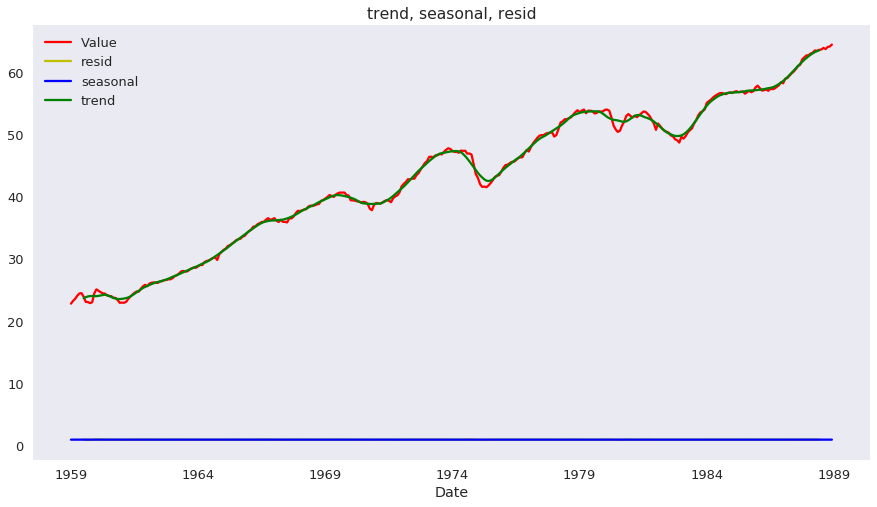

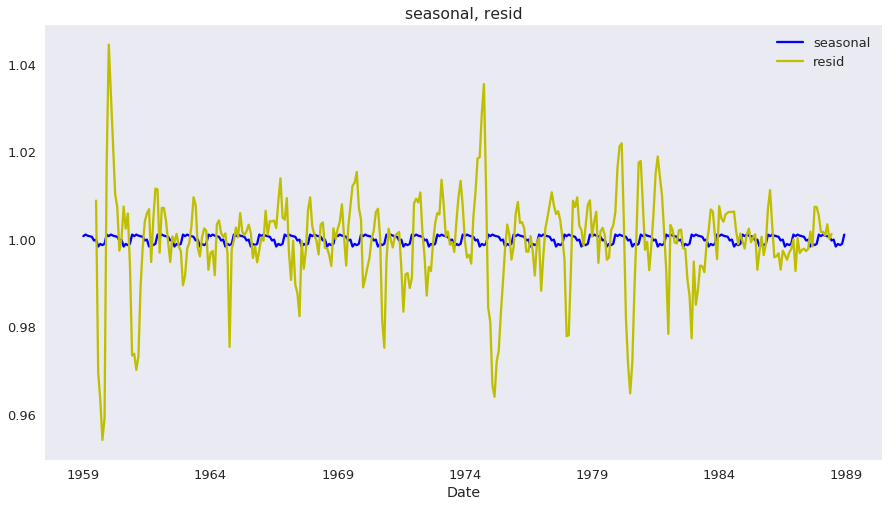

In [142]:
# построим график тренда, сезональности и остатка для мультипликативной модели
tsr = pd.DataFrame(
    {'Value': data['Value'], 'trend': multydec.trend,
     'seasonal': multydec.seasonal,
     'resid': multydec.resid}, data.index)
tsr.plot(title='trend, seasonal, resid', style=['-r', '-y', '-b', '-g'])
tsr[['seasonal', 'resid']].plot(title='seasonal, resid', style=['-b', '-y']);

## Анализ графиков
По графикам видно:
1. У кривой тренда прослеживается свой тренд (как бы нелепо это не звучало ) => трендовый ряд не стационарен  
2. У ряда сезональность и остаток тренда нет => эти ряды стационарны


P.S. это верно и для аддитивной и для мультипликативной моделей

# Часть №3. Построение модели ряда
## Проверка ряда на интегрированость порядка 1
Для проверки временного ряда на интегрированность порядка 1, необходимо сделать следующие:
1. Построить ряд из первых разностей.
2. Проверить: не являеться ли этот ряд стационарным.

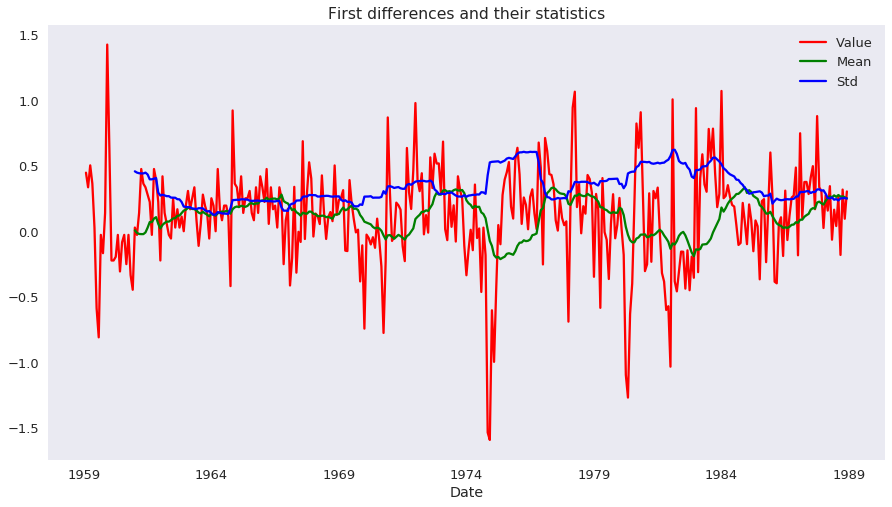

In [143]:
# Вычисление первых разностей и удаление NaN значений.
data_diff = data.diff(periods=1).dropna()

stat = calc_mean_std(data_diff, 24)
stat.plot(title='First differences and their statistics',
          style=['-r', '-g', '-b']);

## Анализ графика
По графику видно:
1. Среднее и стандартное отклонение "постоянны".
2. У ряда не наблюдается тренд. 

На основании этого делаем вывод, что ряд стационарен. Следовательно исходный временной ряд является интегрированным рядом порядка 1.

## Построение модели ARIMA.
Для построения модели нужно определить:
1. Параметр p - порядок компоненты AR (авторегрессионная модель).
1. Параметр q - порядок компоненты MA (модель скользящего среднего).

Для определения этих параметров построим график автокорреляционной функции и график частично автокорреляционной функции для ряда первых разностей.

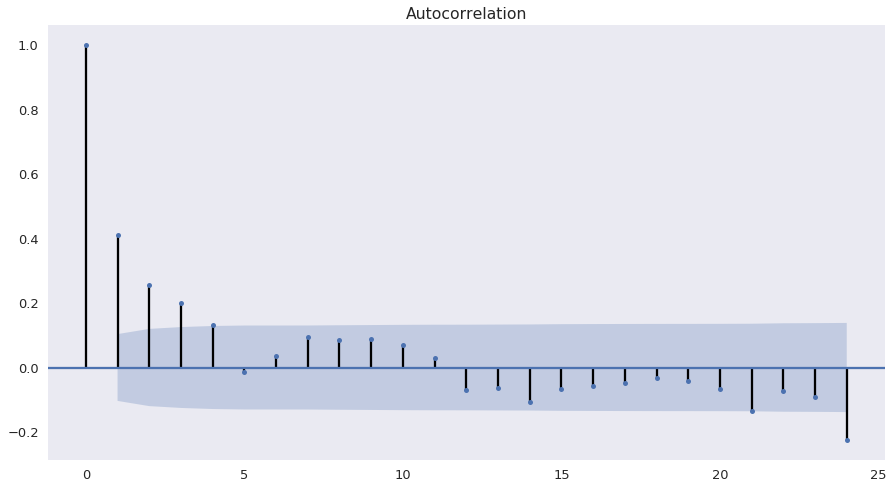

In [144]:
sm.graphics.tsa.plot_acf(data_diff.values, lags=24);

## Анализ графика автокорреляционной функции
По графику видим, что параметр ** q ** будет находится в отрезке от 1 до 5. 

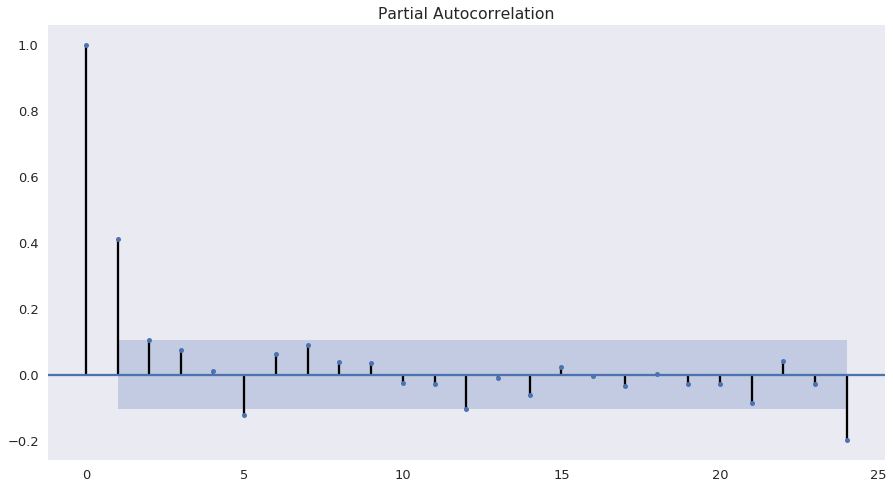

In [145]:
sm.graphics.tsa.plot_pacf(data_diff.values, lags=24);

## Анализ графика частично автокорреляционной функции
По графику видим, что параметр ** p ** будет равен либо 1, либо 2.

## Построение модели ARIMA
Построим различные модели ARIMA для всех комбинаций параметров p и q.

In [146]:
models = []
for p in range(1, 3):
    for q in range(1, 6):
        try:
            mod = sm.tsa.ARIMA(data, order=(p, 1, q)).fit(trend='nc')
            models.append({'p': p, 'q': q, 'mod': mod})
        except:
            pass

## Оценка моделей на исходных данных
### Критерий Акаике

In [147]:
for model in models:
    print('p=%d q=%d aic=%f' % (model['p'], model['q'], model['mod'].aic))

p=1 q=1 aic=255.641365
p=1 q=2 aic=256.958710
p=1 q=3 aic=258.958570
p=1 q=4 aic=255.307087
p=2 q=1 aic=256.854595
p=2 q=2 aic=258.956696


По результатам оценки: все модели хороши, но лучшая - это модель при p равном 1 и q равном 4.

### Коэффициент детерминации

In [148]:
for model in models:
    mod = model['mod']
    res = mod.predict(start=data.index[1], end=data.index[-1], typ='levels')
    rating = r2_score(data[1:].values, res.values)
    print('p=%d q=%d r2_score=%f' % (model['p'], model['q'], rating))

p=1 q=1 r2_score=0.999096
p=1 q=2 r2_score=0.999098
p=1 q=3 r2_score=0.999098
p=1 q=4 r2_score=0.999112
p=2 q=1 r2_score=0.999098
p=2 q=2 r2_score=0.999098


По результатам оценки: все модели хороши, но лучшая - это модель при p равно 1 и q равном 4.

## Оценка моделей по тестовой выборке

### Загрузка тестовой выборки

In [149]:
test = pd.read_csv('testing.csv',
                   sep=',',
                   index_col=['Date'],
                   parse_dates=True)

### Коэффициент детерминации

In [150]:
for model in models:
    mod = model['mod']
    res = mod.predict(start=test.index[0], end=test.index[-1], typ='levels')
    rating = r2_score(test.values, res.values)
    print('p=%d q=%d r2_score=%f' % (model['p'], model['q'], rating))

p=1 q=1 r2_score=-0.024484
p=1 q=2 r2_score=0.013672
p=1 q=3 r2_score=0.015129
p=1 q=4 r2_score=-0.102836
p=2 q=1 r2_score=0.044763
p=2 q=2 r2_score=0.007226


### Графики моделей и тестовой выборки

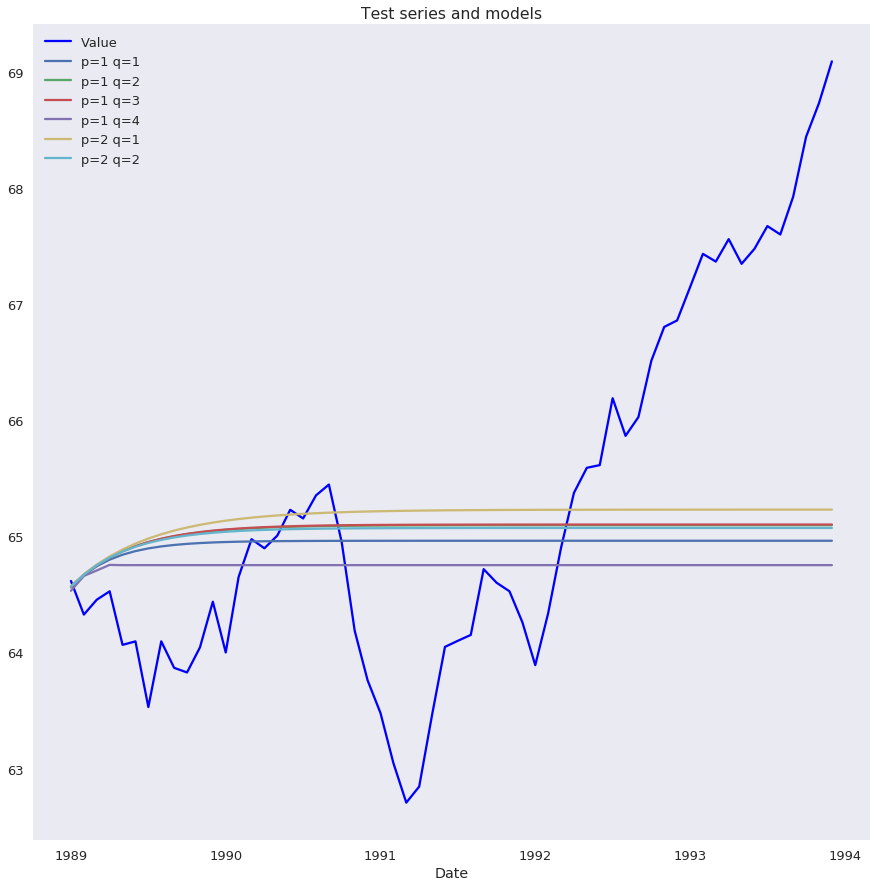

In [151]:
plt.rcParams['figure.figsize'] = (15, 15)

test.plot(title='Test series and models', style='-b')

for model in models:
    mod = model['mod']
    res = mod.predict(start=test.index[0], end=test.index[-1], typ='levels')
    res.plot(label='p=%d q=%d' % (model['p'], model['q']))


plt.legend();

### Графики моделей

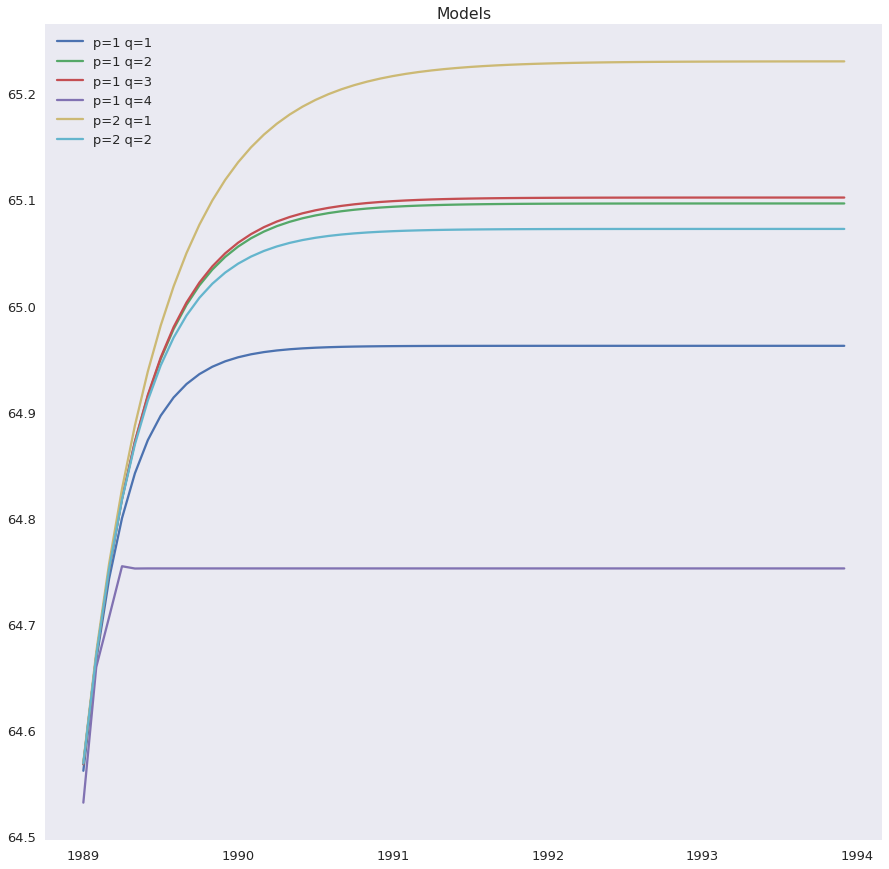

In [152]:
for model in models:
    mod = model['mod']
    res = mod.predict(start=test.index[0], end=test.index[-1], typ='levels')
    res.plot(label='p=%d q=%d' % (model['p'], model['q']))

plt.legend()
plt.title('Models');

## Выводы

По итогам работы можно сделать следующие выводы:
    
1. Модели хорошо себя показывают на исходных данных, но на тестовой выборке большее количество моделей не справилось (если коэффициент детерминации меньше нуля - это плохая модель).
1. По критерию Акаике лучше всего подошла модель ** p ** =  1, ** q ** = 1, но на тестовой выборке лучше всего справилась модель ** p ** = 2, ** q ** = 1.
1. Графики моделей получились очень интересными: сначала модели выходят из одной точки на свой "уровень", а затем стабилизируются. 
1. Построение моделей временных рядов довольно сложная вещь, но благодаря языку python и его библиотекам этот процесс был в разы легче.